In [1]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms
from torchvision.utils import make_grid

from torch.utils.data import random_split, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import os

## **Loading the Dataset**

In [2]:
train_dataset = FashionMNIST(root='./data',
                             train=True,
                             transform=transforms.ToTensor(),
                             download=False)

In [3]:
test_dataset = FashionMNIST(root='./data',
                            train=False,
                            transform=transforms.ToTensor())

## **Separating the Dataset**

In [4]:
torch.manual_seed(27)

In [5]:
train_size = int(len(train_dataset) * 0.9)

In [6]:
val_size = int(len(train_dataset) * 0.1)

In [7]:
train_dataset, val_dataset = random_split(train_dataset, lengths=[train_size, val_size])

## **Creating the Dataloader Object**

In [8]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=64,
                              shuffle=True,
                              num_workers=2)

In [9]:
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=64,
                             shuffle=False,
                             num_workers=2)

In [10]:
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=64,
                            shuffle=False,
                            num_workers=2)

## **Analysis of Class Distribution**

### **Train**

In [11]:
train_counter = Counter()

In [12]:
for _, labels in train_dataloader:
    train_counter.update(labels.tolist())

In [13]:
print("Train label distribution: ", sorted(train_counter.items()))

Train label distribution:  [(0, 5402), (1, 5411), (2, 5407), (3, 5373), (4, 5382), (5, 5373), (6, 5409), (7, 5406), (8, 5390), (9, 5447)]


### **Test**

In [14]:
test_counter = Counter()

In [15]:
for _, labels in test_dataloader:
    test_counter.update(labels.tolist())

In [16]:
print("Test label distribution: ", sorted(test_counter.items()))

Test label distribution:  [(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


### **Val**

In [17]:
val_counter = Counter()

In [18]:
for _, labels in val_dataloader:
    val_counter.update(labels.tolist())

In [19]:
print("Val label distribution: ", sorted(val_counter.items()))

Val label distribution:  [(0, 598), (1, 589), (2, 593), (3, 627), (4, 618), (5, 627), (6, 591), (7, 594), (8, 610), (9, 553)]


## **Viewing some Data**

In [20]:
for image, _ in train_dataloader:
    break

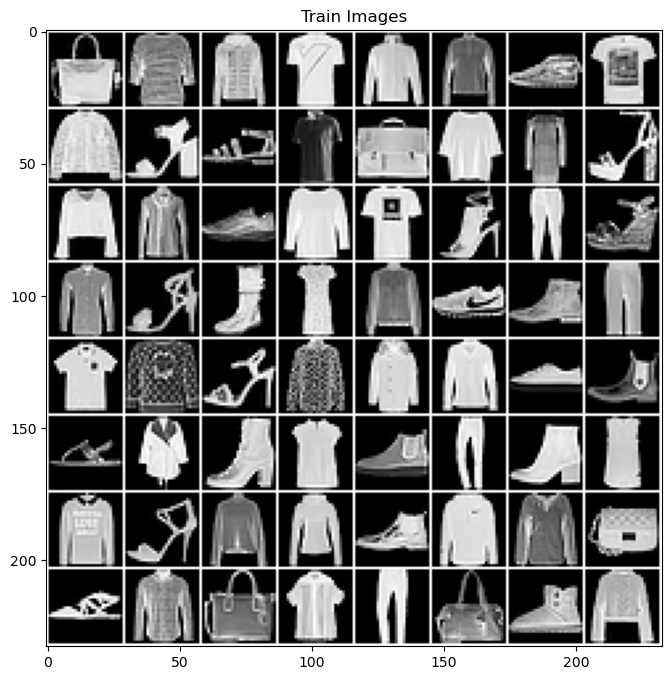

In [21]:
plt.figure(figsize=(8,8))
plt.title('Train Images')
plt.imshow(np.transpose(make_grid(image[:64],
                                  padding=1,
                                  pad_value=1.0,
                                  normalize=True), (1,2,0)))

## **MLP**

In [22]:
class MLP(torch.nn.Module):
  def __init__(self, input, output):
    super().__init__()

    self.layers = torch.nn.Sequential(
        torch.nn.Linear(input, 256),
        torch.nn.ReLU(),

        torch.nn.Linear(256, 128),
        torch.nn.ReLU(),

        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),

        torch.nn.Linear(64, output),
    )

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    return self.layers(x)

In [23]:
height,width = image[0].shape[1:]

In [24]:
input_size = height * width

In [25]:
model = MLP(input_size, 10).to('cuda')

In [26]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [27]:
if not os.path.exists('logs'):
    os.mkdir('logs')

log_writer = SummaryWriter(log_dir='logs/PerceptronFashionMNIST')

## **Finding the Best Learning Rate**

In [34]:
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [35]:
epochs = 100

In [36]:
model.train()

for epoch in range(epochs):

    epoch_loss = 0.0
    for x,y in train_dataloader:
        x = x.to('cuda')
        y = y.to('cuda')

        z = model(x)
        loss = F.cross_entropy(z, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    sch.step()

    epoch_loss /= len(train_dataloader)

    log_writer.add_scalar('Loss/Epoch', epoch_loss, epoch)
    log_writer.add_scalar('LR/Epoch', optimizer.param_groups[0]['lr'], epoch)

## **Traning**

In [28]:
def accuracy(model, dataloader):
  model = model.eval()

  accuracy = 0.0
  total = 0

  for x,y in dataloader:
    x = x.to('cuda')
    y = y.to('cuda')

    with torch.inference_mode():
      z = model(x)

    labels = torch.argmax(z, dim=1)
    labels = labels.view(y.shape).to(y.dtype)

    results = labels == y
    accuracy += torch.sum(results).item()
    total += results.numel()

  return (accuracy/total)

In [29]:
model = MLP(input_size, 10).to('cuda')
optimizer = torch.optim.SGD(model.parameters(), lr=0.35) 

In [30]:
epochs = 10

In [31]:
for epoch in range(epochs):
  model = model.train()

  for index, (x, y) in enumerate(train_dataloader):
    x = x.to('cuda')
    y = y.to('cuda')

    z = model(x)
    loss = F.cross_entropy(z, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if index % 100 == 0:
      print(f'Epoch: {epoch+1:03d}/{epochs:03d} - Batch: {index+1:03d}/{len(train_dataloader):03d} - Loss: {loss:.2f}')

  print(f'Train Accuracy: {accuracy(model, train_dataloader)*100:0.2f}% - Val Accuracy: {accuracy(model, val_dataloader)*100:.2f}%')

Epoch: 001/010 - Batch: 001/844 - Loss: 2.28
Epoch: 001/010 - Batch: 101/844 - Loss: 0.99
Epoch: 001/010 - Batch: 201/844 - Loss: 1.54
Epoch: 001/010 - Batch: 301/844 - Loss: 0.52
Epoch: 001/010 - Batch: 401/844 - Loss: 0.92
Epoch: 001/010 - Batch: 501/844 - Loss: 0.45
Epoch: 001/010 - Batch: 601/844 - Loss: 0.69
Epoch: 001/010 - Batch: 701/844 - Loss: 0.39
Epoch: 001/010 - Batch: 801/844 - Loss: 0.45
Train Accuracy: 78.93% - Val Accuracy: 79.78%
Epoch: 002/010 - Batch: 001/844 - Loss: 0.43
Epoch: 002/010 - Batch: 101/844 - Loss: 0.46
Epoch: 002/010 - Batch: 201/844 - Loss: 0.43
Epoch: 002/010 - Batch: 301/844 - Loss: 0.36
Epoch: 002/010 - Batch: 401/844 - Loss: 0.26
Epoch: 002/010 - Batch: 501/844 - Loss: 0.57
Epoch: 002/010 - Batch: 601/844 - Loss: 0.27
Epoch: 002/010 - Batch: 701/844 - Loss: 0.45
Epoch: 002/010 - Batch: 801/844 - Loss: 0.37
Train Accuracy: 84.30% - Val Accuracy: 83.65%
Epoch: 003/010 - Batch: 001/844 - Loss: 0.29
Epoch: 003/010 - Batch: 101/844 - Loss: 0.26
Epoch: 0

## **Evaluating the Results**

In [32]:
print(f'Test Accuracy: {accuracy(model, test_dataloader)*100:0.2f}%')

Test Accuracy: 85.72%
